In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import folium as fol

In [13]:
plt.rc('font', family = 'Malgun Gothic') #한글이 깨져 폰트를 지정해줬습니다.

In [3]:
df = pd.read_csv('Desktop/pjec/서울특별시 전월세가 정보.csv',engine='python', encoding='CP949')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4507911 entries, 0 to 4507910
Data columns (total 22 columns):
 #   Column   Dtype  
---  ------   -----  
 0   지번코드     object 
 1   기관코드     int64  
 2   일련번호     int64  
 3   접수년도     int64  
 4   자치구코드    int64  
 5   자치구명     object 
 6   법정동코드    int64  
 7   법정동명     object 
 8   본번       float64
 9   부번       float64
 10  건물명      object 
 11  층        float64
 12  임대건물코드   int64  
 13  임대건물명    object 
 14  임대면적     float64
 15  전월세구분코드  int64  
 16  전월세구분    object 
 17  보증금      int64  
 18  임대료      int64  
 19  계약년도     int64  
 20  계약일자     int64  
 21  건축년도     float64
dtypes: float64(5), int64(11), object(6)
memory usage: 756.6+ MB


In [4]:
df1 = df[['자치구명', '법정동명', '임대면적', '전월세구분', '보증금', '임대료', '법정동코드']]
iwant = df1[(df['보증금'] <= 5000) & (df['임대료'] <= 50) & (df['임대면적'] > 20)] 
iwant_group = iwant.groupby(['자치구명', '법정동명']).count() #법정동명은 nan값이 없으므로 주택의 수를 표현하는데 이용하겠습니다.

In [5]:
t = iwant_group.reset_index()   #뒤의 merge병합을 위해 인덱스를 지워줍니다.
t = t.rename(columns={"법정동코드":"주택수"})   #주택수를 나타내는 column이 없으므로 법정동 코드를 주택수로 변경해주겠습니다
t

,자치구명,법정동명,임대면적,전월세구분,보증금,임대료,주택수
0,강남구,개포동,3385,3385,3385,3385,3385
1,강남구,논현동,2317,2317,2317,2317,2317
2,강남구,대치동,1606,1606,1606,1606,1606
3,강남구,도곡동,656,656,656,656,656
4,강남구,삼성동,1036,1036,1036,1036,1036
...,...,...,...,...,...,...,...
399,중랑구,면목동,19900,19900,19900,19900,19900
400,중랑구,묵동,4589,4589,4589,4589,4589
401,중랑구,상봉동,4156,4156,4156,4156,4156
402,중랑구,신내동,2392,2392,2392,2392,2392


In [6]:
where = pd.read_csv('Desktop/pjec/서울시 위도경도.csv', engine='python', encoding='utf-8') #자치구의 위도 및 경도입니다.


In [7]:
where1 = where.groupby(['시군구'], as_index=False).mean()  #지도에 좀 더 직관성을 주기위해 위도, 경도를 구 단위로 합쳐줬습니다. 
where1 = where1.reset_index()
where1 = where1.rename(columns={"시군구":"자치구명"})

In [8]:
iwantwhe = pd.merge(t, where1, how='inner')
my_lat = iwantwhe['위도'].mean()
my_long = iwantwhe['경도'].mean()
map_osm = fol.Map(location=[my_lat, my_long], zoom_start=12, tiles='Stamen Terrain')
map_osm

In [9]:
for item in iwantwhe.index:
    lat = iwantwhe.loc[item, '위도']
    long = iwantwhe.loc[item, '경도']
    tooltip = iwantwhe.loc[item, '자치구명']
    radius = iwantwhe.loc[item, '주택수'] / 200
    fol.CircleMarker([lat, long],
                     tooltip = tooltip,
                     radius = radius,
                       color = 'skyblue',
                    fill = True).add_to(map_osm)
map_osm

<AxesSubplot:xlabel='자치구명', ylabel='주택수'>

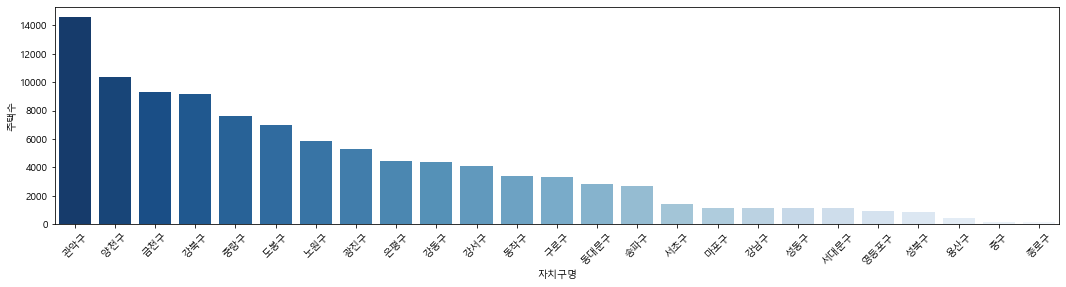

In [15]:
plt.figure(figsize=(18,4))          #
sort_iwantwhe = iwantwhe.pivot_table(index='자치구명', values='주택수').sort_values(by='주택수', ascending=False)
plt.xticks(rotation= 45)
sns.barplot(
            data=sort_iwantwhe,
            x=sort_iwantwhe.index,
            y='주택수',
    palette='Blues_r'
            )

In [418]:
df = pd.read_csv('Desktop/pjec/소상공인시장진흥공단_상가(상권)정보_서울_202109.csv',engine='python')#다음으로는 생활 기반시설들에 대해 분석을 하겠습니다.

In [126]:
df1 = df[['시군구명', '행정동명', '상권업종대분류명','상권업종중분류명']]
df1

,시군구명,행정동명,상권업종대분류명,상권업종중분류명
0,송파구,거여2동,소매,의복의류
1,영등포구,영등포동,소매,건강/미용식품
2,성동구,용답동,소매,취미/오락관련소매
3,동작구,사당2동,음식,한식
4,종로구,종로1.2.3.4가동,음식,한식
...,...,...,...,...
325875,마포구,망원2동,부동산,부동산중개
325876,은평구,녹번동,소매,시계/귀금속소매
325877,은평구,신사2동,소매,애견/애완/동물
325878,광진구,중곡2동,음식,커피점/카페


In [127]:
need = df1[df1['상권업종대분류명'].isin(['음식', '소매','스포츠'])]    #제가 원하는 시설 분류입니다.
needs = need.groupby(['시군구명', '상권업종대분류명']).count()
needs

행정동명  상권업종중분류명
시군구명 상권업종대분류명                 
강남구  소매         7832      7832
     스포츠         606       606
     음식        12095     12095
강동구  소매         3441      3442
     스포츠         188       188
...              ...       ...
중구   스포츠         130       130
     음식         4790      4790
중랑구  소매         3174      3174
     스포츠         110       110
     음식         3564      3564

[75 rows x 2 columns]

In [128]:
needs = needs.reset_index()   
needs = needs.rename(columns={"상권업종중분류명":"점포수"})   
needs

,시군구명,상권업종대분류명,행정동명,점포수
0,강남구,소매,7832,7832
1,강남구,스포츠,606,606
2,강남구,음식,12095,12095
3,강동구,소매,3441,3442
4,강동구,스포츠,188,188
...,...,...,...,...
70,중구,스포츠,130,130
71,중구,음식,4790,4790
72,중랑구,소매,3174,3174
73,중랑구,스포츠,110,110


<AxesSubplot:xlabel='시군구명', ylabel='점포수'>

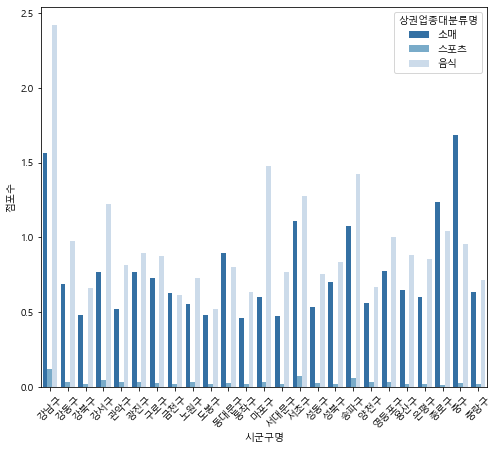

In [129]:
plt.figure(figsize=(8,7))

plt.xticks(rotation= 45)

y = needs['점포수']/5000
sns.barplot(
            data=needs,
            x=needs['시군구명'],
            y=y,
            hue='상권업종대분류명',
            palette='Blues_r'
            )

In [122]:
need1 = df1                                               #위의 플롯은 복잡해보여 총 점포수로 직관적이게 보이려고 다시 만들었습니다.
needs1 = need1.groupby(['시군구명', '행정동명']).count()
needs1

상권업종대분류명  상권업종중분류명
시군구명 행정동명                    
강남구  개포1동        99        99
     개포2동       632       632
     개포4동       589       589
     논현1동      2046      2046
     논현2동      2589      2589
...             ...       ...
중랑구  상봉2동       855       855
     신내1동       724       724
     신내2동       399       399
     중화1동       568       568
     중화2동       960       960

[425 rows x 2 columns]

In [136]:
needs1 = needs1.reset_index()   
needs1 = needs1.rename(columns={"상권업종중분류명":"점포수"})   
needs1

,level_0,index,시군구명,점포수,상권업종대분류명,점포수
0,0,0,강남구,개포1동,99,99
1,1,1,강남구,개포2동,632,632
2,2,2,강남구,개포4동,589,589
3,3,3,강남구,논현1동,2046,2046
4,4,4,강남구,논현2동,2589,2589
...,...,...,...,...,...,...
420,420,420,중랑구,상봉2동,855,855
421,421,421,중랑구,신내1동,724,724
422,422,422,중랑구,신내2동,399,399
423,423,423,중랑구,중화1동,568,568


<AxesSubplot:xlabel='시군구명', ylabel='점포수'>

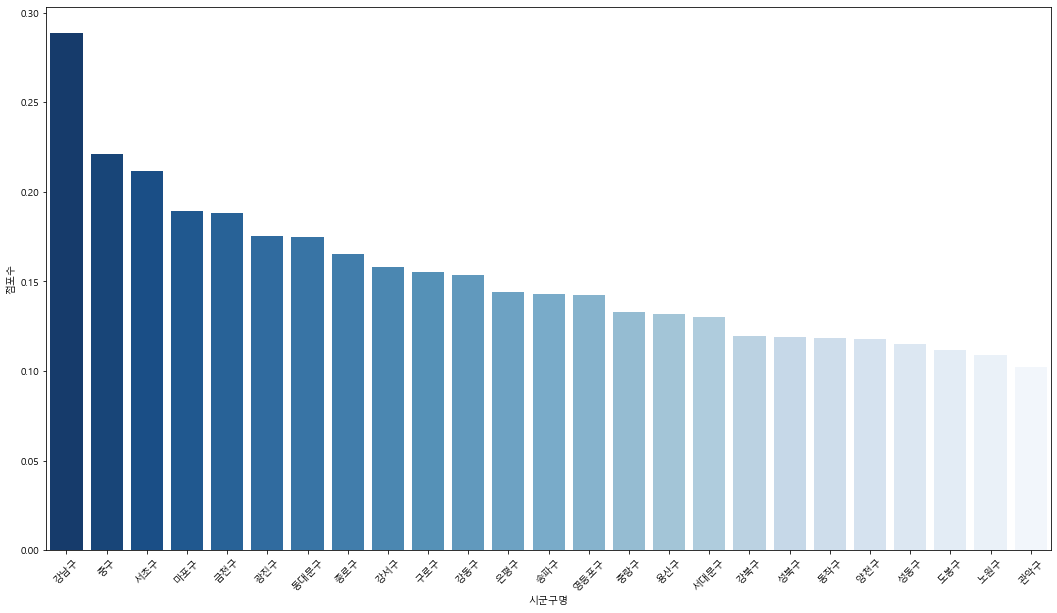

In [189]:
plt.figure(figsize=(18,10))          
sort_needs1 = needs1.pivot_table(index='시군구명', values='점포수').sort_values(by='점포수', ascending=False)
plt.xticks(rotation= 45)
y=sort_needs1['점포수']/5000
sns.barplot(
            data=sort_needs1,
            x=sort_needs1.index,
            y=y,
    palette='Blues_r'
            )

In [419]:
df = pd.read_csv('Desktop/pjec/report.txt', sep = "\t", engine='python')

<AxesSubplot:xlabel='지역', ylabel='인구밀도(명/㎢)'>

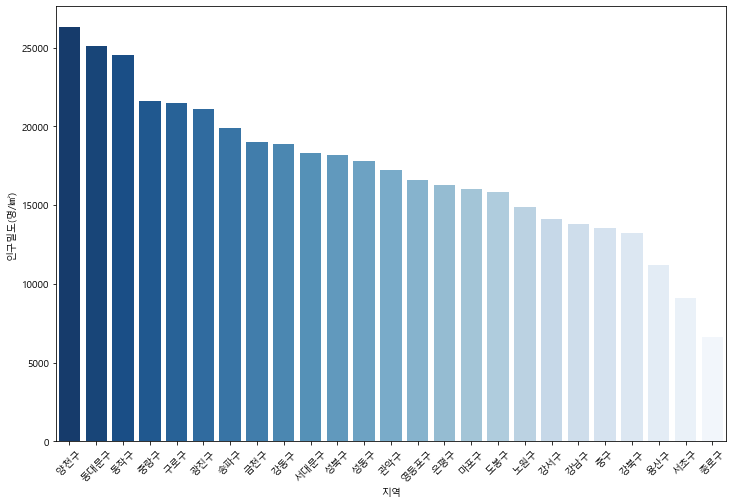

In [211]:
plt.figure(figsize=(12,8))          
plt.xticks(rotation= 45)

sns.barplot(
            data=df,
            x='지역',
            y='인구밀도(명/㎢)',
            palette='Blues_r'
            )

In [354]:
df = pd.read_csv('Desktop/pjec/문화공간.csv', sep=',', engine='python', encoding='cp949')
df = df[['X좌표', 'Y좌표']]         #데이터에 뜬금없게 잠실역이 들어있어 오류가 발생했습니다.
df['X좌표'] = pd.to_numeric(df['X좌표'], errors='coerce')        #0이나 문자열, 위도 경도가 바뀐 행들을 제거하는 전처리 과정입니다.
df['Y좌표'] = pd.to_numeric(df['Y좌표'], errors='coerce') 
df = df.dropna(axis=0)
A = df[df['X좌표'] == '0'].index
B = df[df['Y좌표'] == '0'].index
df = df[df.X좌표 < 120]
df = df[df.X좌표 > 0]
df = df[df.Y좌표 > 120]                                     #Y좌표는 전부 120이상이라 한줄만 적었습니다.
df['X좌표'] = df['X좌표'].astype(float)
df['Y좌표'] = df['Y좌표'].astype(float)
df.isnull().sum()

X좌표    0
Y좌표    0
dtype: int64

In [377]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=25,max_iter=1000,random_state=50).fit(df[['X좌표','Y좌표']])      #25개의 자치구로 분류를 해주고싶었습니다.
labels=kmeans.labels_
centers=kmeans.cluster_centers_
df['clustering']=labels

In [378]:
df['clustering'] = df['clustering'].astype(float)         #클러스터링 결과값도 형변환을 해주었습니다.

In [379]:
my_lat = df['X좌표'].mean()
my_long = df['Y좌표'].mean()
map_osm = fol.Map(location=[my_lat, my_long], zoom_start=10, tiles='Stamen Terrain')

In [380]:
for item in df.index:                        #문화시설의 분포를 지도로 나타내었습니다
    lat = df.loc[item, 'X좌표']
    long = df.loc[item, 'Y좌표']
    radius = df.loc[item, 'clustering']
    tooltip = df.loc[item, 'clustering']
    fol.CircleMarker([lat, long],
                     radius = radius,
                     tooltip = tooltip,
                       color = 'pink',
                    fill = True).add_to(map_osm)
map_osm

In [397]:
tail = df.groupby(['clustering'], as_index=False).mean()  
tail#다시 클러스터링을 이용해 클러스터링값에 자치구 이름을 붙여줄겁니다.

,clustering,X좌표,Y좌표
0,0,37.573205,126.980256
1,1,35.020762,126.781934
2,2,37.524008,127.053107
3,3,37.465144,126.901591
4,4,36.485435,127.260629
5,5,37.640432,127.019009
6,6,37.554300,126.930379
7,7,37.579868,127.047346
8,8,37.554073,126.840206
9,9,37.545937,127.123103


In [406]:
front =iwantwhe.reset_index()
front = front[['자치구명', '위도', '경도']]
front = front.groupby(['자치구명'], as_index=False).mean()

In [407]:
last = pd.concat( [front, tail], axis = 1)  #문화시설의 클러스터번호를 자치구명으로 바꿔주고 싶었으나 
last                                        #위치가 틀린부분이 많아 사용하지는 못하였습니다 보완하고싶습니다...

,자치구명,위도,경도,clustering,X좌표,Y좌표
0,강남구,37.498323,127.056864,0,37.573205,126.980256
1,강동구,37.533858,127.130330,1,35.020762,126.781934
2,강북구,37.631878,127.023328,2,37.524008,127.053107
3,강서구,37.550855,126.848273,3,37.465144,126.901591
4,관악구,37.477713,126.938729,4,36.485435,127.260629
5,광진구,37.541001,127.082505,5,37.640432,127.019009
6,구로구,37.495619,126.883665,6,37.554300,126.930379
7,금천구,37.458949,126.894467,7,37.579868,127.047346
8,노원구,37.648159,127.068636,8,37.554073,126.840206
9,도봉구,37.668639,127.047364,9,37.545937,127.123103


In [416]:
kmeans = KMeans(n_clusters=25,max_iter=1000,random_state=50).fit(last[['위도','경도']])     
labels=kmeans.labels_
centers=kmeans.cluster_centers_
last['clustering']=labels

In [417]:
last

,자치구명,위도,경도,clustering,X좌표,Y좌표
0,강남구,37.498323,127.056864,13,37.573205,126.980256
1,강동구,37.533858,127.130330,9,35.020762,126.781934
2,강북구,37.631878,127.023328,15,37.524008,127.053107
3,강서구,37.550855,126.848273,7,37.465144,126.901591
4,관악구,37.477713,126.938729,14,36.485435,127.260629
5,광진구,37.541001,127.082505,2,37.640432,127.019009
6,구로구,37.495619,126.883665,4,37.554300,126.930379
7,금천구,37.458949,126.894467,17,37.579868,127.047346
8,노원구,37.648159,127.068636,5,37.554073,126.840206
9,도봉구,37.668639,127.047364,22,37.545937,127.123103


ParserError: ';' expected after '"'